# Texture segmentation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd


from skimage import io, img_as_ubyte, measure
from skimage.filters import threshold_otsu
from skimage.filters.rank import entropy
from skimage.morphology import disk, square, closing, binary_dilation, binary_erosion
from skimage.color import label2rgb, rgb2gray
from skimage.segmentation import clear_border
from scipy import ndimage

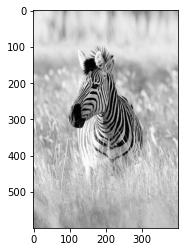

In [3]:
img = io.imread("../inpdata/images/zebra.jpg", as_gray=True)
plt.imshow(img, cmap="gray")

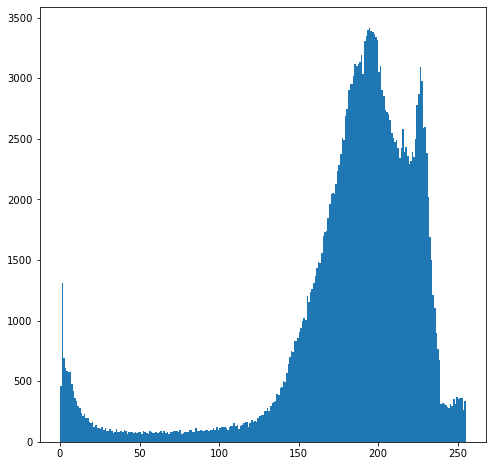

In [16]:
fig = plt.figure(figsize=(8, 8))
plt.hist(img_as_ubyte(img.flatten()), bins=255, range=(0, 255))
plt.show()

In [30]:
# Variance Calculation
kernel_size = 15
eimg = ndimage.uniform_filter(img, (kernel_size, kernel_size))
eimgsq = ndimage.uniform_filter(img ** 2, (kernel_size, kernel_size))
dimg = eimgsq - eimg ** 2

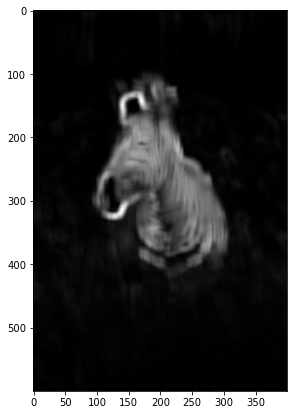

In [31]:
fig = plt.figure(figsize=(7, 7))
plt.imshow(dimg, cmap = "gray")

# Entropy

In [65]:
entropy_img = entropy(img_as_ubyte(img), disk(5))

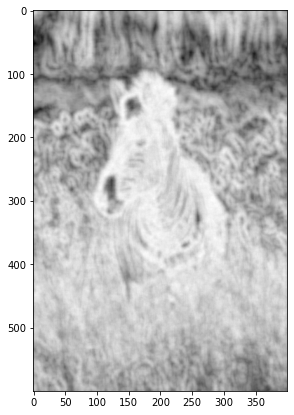

In [66]:
fig = plt.figure(figsize=(7, 7))
plt.imshow(entropy_img, cmap="gray")

In [67]:
thresh = threshold_otsu(entropy_img)

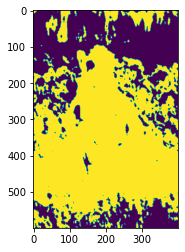

In [68]:
plt.imshow(np.digitize(entropy_img, bins=[thresh]))

# Image segmentation followed by measurements


In [3]:
img = img_as_ubyte(io.imread("../inpdata/images/cast_iron1.tif", as_gray=True))
img

array([[155, 156, 154, ..., 150, 150, 147],
       [156, 157, 156, ..., 152, 150, 146],
       [157, 158, 157, ..., 152, 152, 149],
       ...,
       [159, 160, 161, ..., 150, 149, 149],
       [159, 160, 161, ..., 149, 149, 149],
       [159, 160, 160, ..., 149, 150, 149]], dtype=uint8)

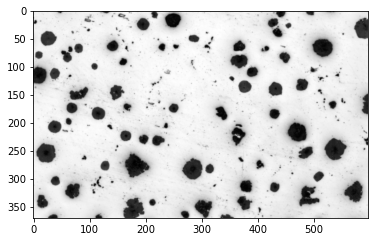

In [6]:
plt.imshow(img, cmap = "gray")

In [7]:
scale = 0.6 # microns / pixel

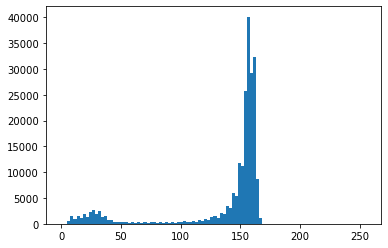

In [10]:
plt.hist(img.flat, bins = 100, range=(0, 255))
plt.show()

In [12]:
threshold = threshold_otsu(img)
threshold

93

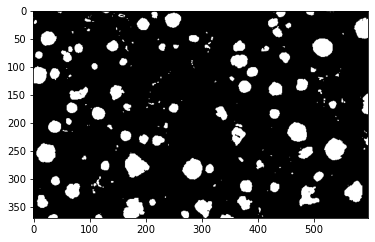

In [14]:
thresholded_img = img < threshold
plt.imshow(thresholded_img, cmap = "gray")

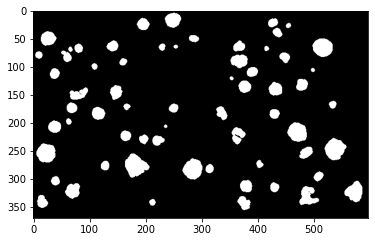

In [35]:
eros_img = binary_erosion(thresholded_img, disk(3))
dil_img = binary_dilation(eros_img, disk(3))
dil_img = clear_border(dil_img)
plt.imshow(dil_img, cmap = "gray")

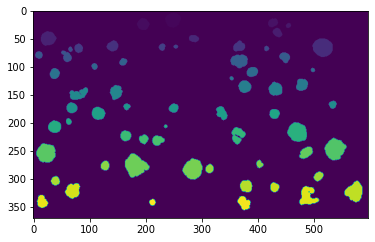

In [37]:
labeled_img = measure.label(dil_img)
plt.imshow(labeled_img)

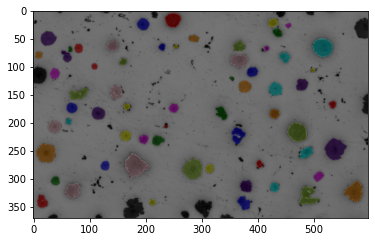

In [39]:
img_with_overlay = label2rgb(labeled_img, image = img)
plt.imshow(img_with_overlay)

## Measure properties for segmented image

In [42]:
props = measure.regionprops_table(labeled_img, img,
                                  properties=[
                                      "label", "area", "equivalent_diameter",
                                      "mean_intensity", "solidity"
                                  ])

In [45]:
df = pd.DataFrame(props)
df.head()

,label,area,equivalent_diameter,mean_intensity,solidity
0,1,582,27.221782,19.163230,0.955665
1,2,362,21.468878,32.165746,0.952632
2,3,220,16.736568,31.627273,0.940171
3,4,65,9.097284,46.676923,0.878378
4,5,207,16.234549,25.821256,0.940909


# Blob detector for image segmentation
Blob stands for Binary Large Object and refers to a group of connected pixels in a binary image.
So BLOB is a group of pixels that share some common property (e.g. grayscale value).

In [47]:
# The first steps are the same to the previous section img -> thresholding -> binary mask
params = cv2.SimpleBlobDetector_Params()

params.minThreshold = 0
params.maxThreshold = 255

params.filterByArea = True
params.minArea = 50
params.maxArea = 10000

params.filterByColor = False
params.blobColor = 0

params.filterByCircularity = True
params.minCircularity = 0.5
params.maxCircularity = 1

params.filterByConvexity = True
params.minConvexity = 0.5
params.maxConvexity = 1

params.filterByInertia = True
params.minInertiaRatio = 0
params.maxInertiaRatio = 1

params.minDistBetweenBlobs = 0

In [48]:
detector = cv2.SimpleBlobDetector_create(params)

In [49]:
keypoints = detector.detect(img)
len(keypoints)

82

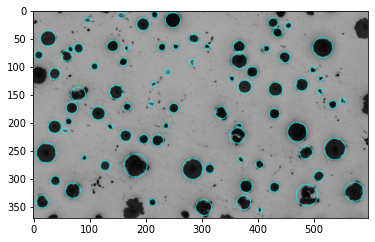

In [52]:
img_with_blobs = cv2.drawKeypoints(img, keypoints, np.array([]), (0, 255, 255),
                                  cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_with_blobs)

# Image segmentation using watershed

Here we will use opencv implementation for image segmentation. To do this we should specify pixels which are background, and pixels which are foreground.
This can be done by using any previous segmentation technique. As a result of this we will have mask for background and foreground.

Usually foreground correpsonds to objects in which we are interested. Idea is the following one:
1. Use dilation for foreground, this will help us determine the background.
2. Use erosion for foreground, this will help up determine the foreground.

In [2]:
img = io.imread("../inpdata/images/Osteosarcoma_01.tif")
img.shape

(1104, 1376, 3)

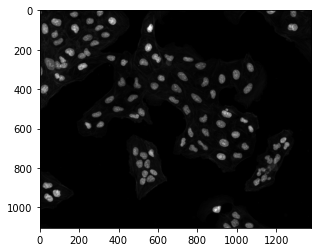

In [4]:
nuclei_channel = img[:, :, 2]
plt.imshow(nuclei_channel, cmap = "gray")

In [6]:
thresh, thresh_img = cv2.threshold(nuclei_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

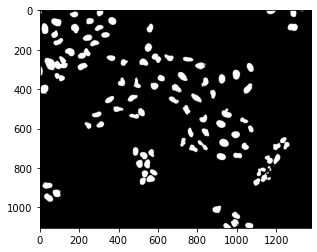

In [9]:
plt.imshow(thresh_img, cmap = "gray")

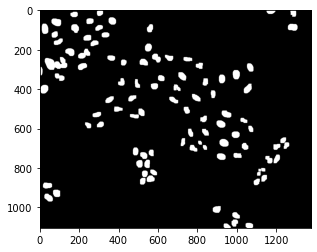

In [13]:
# we can remove small particles (noise) from our mask by using opening
kernel = np.ones((7, 7), np.uint8)
open_img = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel, iterations = 2)
plt.imshow(open_img, cmap = "gray")

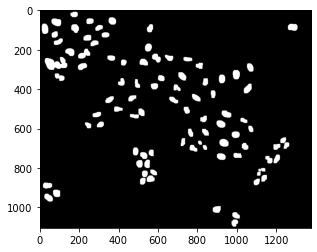

In [14]:
# let's remove objects that are touching the borders
open_img = clear_border(open_img)
plt.imshow(open_img, cmap="gray")

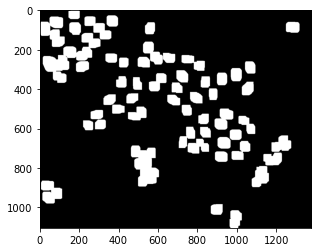

In [18]:
sure_bg = cv2.dilate(open_img, kernel=np.ones((3, 3), dtype=np.uint8), iterations=10)
plt.imshow(sure_bg, cmap="gray")

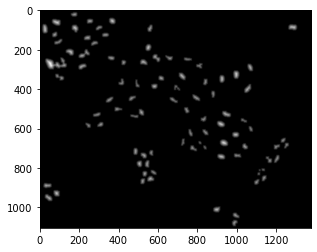

In [27]:
# Now we should specify "sure" foreground. This step can be done by using erosion
# but we will use distance transformation
dist_transformed = cv2.distanceTransform(open_img, cv2.DIST_L2, 5)
plt.imshow(dist_transformed, cmap = "gray")

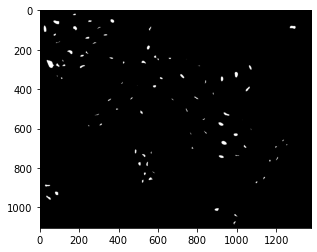

In [29]:
thresh2, sure_fg = cv2.threshold(dist_transformed, 0.5 * dist_transformed.max(), 255, 0)
plt.imshow(sure_fg, cmap = "gray")

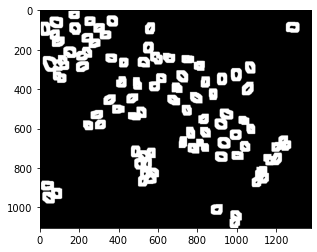

In [32]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown, cmap = "gray")

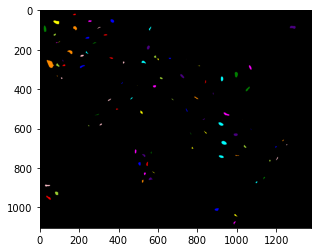

In [34]:
# now our task is to create a unique marker for each element from sure foreground
# this can be acomplished by using the connected components function
thresh3, markers = cv2.connectedComponents(sure_fg)
plt.imshow(label2rgb(markers))

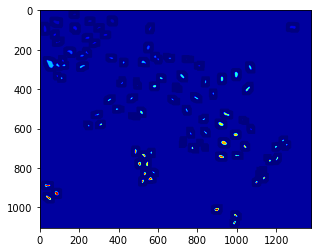

In [37]:
# now for running watershed we should specify unknown region as 0
# foreground and background should have different non zero values
markers = 1 + markers
markers[unknown == 255] = 0
plt.imshow(markers, cmap="jet")

In [38]:
markers = cv2.watershed(img, markers)

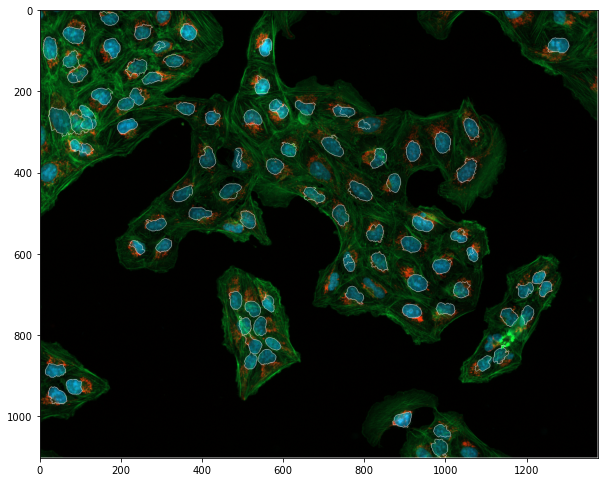

In [39]:
# markers == -1 for boundaries of the object
cell_outline = np.copy(img)
cell_outline[markers == -1] = [255, 255, 255]

fig = plt.figure(figsize=(10, 10))
plt.imshow(cell_outline)

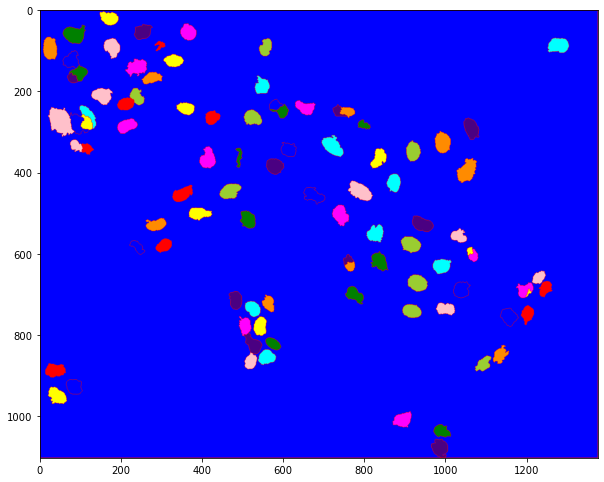

In [45]:
# plot just labeled image
fig = plt.figure(figsize=(10, 10))
plt.imshow(label2rgb(markers))

# Object detection by template matching

You can check info [here](https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html)